# AutoEncoder-based Image Compression

An example of using a simple AutoEncoder architecture to compress images. There are comparisons to JPEG encoding as well.

In [1]:
import time
import io
import functools
import pathlib
import glob
from typing import Callable, List
from PIL import Image

import numpy as np
import pandas as pd
import torch
from torchvision.io import read_image
from torchvision.io import ImageReadMode
import matplotlib.pyplot as plt

In [2]:
IMG_PATH = "/home/zachcoleman/burnt-ends/data/coco/images/"
IMG_SIZE = (512, 512)

In [3]:
class ImageDataset:
    def __init__(self, img_dir, transforms: List[Callable] = None, ext = "jpg"):
        self.filepaths = glob.glob(str(pathlib.Path(img_dir) / f"*.{ext}"))
        if transforms is None:
            self.transforms = []
        else:
            self.transforms = transforms
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_tens = read_image(self.filepaths[idx], mode=ImageReadMode.RGB)
        for t in self.transforms:
            img_tens = t(img_tens)
        return img_tens
    
    @classmethod
    def plot(cls, x, ax = None):
        if ax is None:
            return plt.imshow(x.permute([1, 2, 0]).numpy())
        else:
            return ax.imshow(x.permute([1, 2, 0]).numpy())

In [4]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, padding):
        super().__init__()        
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        self.norm = torch.nn.BatchNorm2d(out_channels)
        self.act = torch.nn.LeakyReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x

In [20]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, compressed_output_channels):
        super().__init__()        
        self.compressed_output_channels = compressed_output_channels
        self.multiply_expand_factor = torch.nn.Parameter(torch.tensor([100.]))
        # self.encode_layers = [
        #     ConvBlock(3, 32, 7, 2, 3),
        #     ConvBlock(32, 64, 5, 2, 2),
        #     ConvBlock(64, compressed_output_channels, 1, 1, "same")
        # ]
        # self.decode_layers = [
        #     torch.nn.ConvTranspose2d(compressed_output_channels, 16, 4, 2, 1),
        #     torch.nn.ConvTranspose2d(16, 32, 4, 2, 1),
        #     ConvBlock(32, 3, 3, 1, "same")
        # ]
        self.encode_layers = [
            ConvBlock(3, 16, 3, 2, 1),
            ConvBlock(16, 32, 3, 2, 1),
            ConvBlock(32, 64, 3, 1, "same"),
            ConvBlock(64, 64, 3, 1, "same"),
            ConvBlock(64, compressed_output_channels, 1, 1, "same")
        ]
        self.decode_layers = [
            torch.nn.ConvTranspose2d(compressed_output_channels, 16, 4, 2, 1),
            torch.nn.ConvTranspose2d(16, 32, 4, 2, 1),
            ConvBlock(32, 16, 3, 1, "same"),
            ConvBlock(16, 3, 1, 1, "same"),

        ]
        self.encode_layers = torch.nn.ModuleList(self.encode_layers)
        self.decode_layers = torch.nn.ModuleList(self.decode_layers)
        self.register_parameter("multiply_expand_factor", self.multiply_expand_factor)
        
    def get_compression_ratio(self):
        tmp = torch.randn(1, 3, 512, 512, device=next(self.parameters()).device)
        compressed = self.compress(tmp)
        data_pts = lambda l: functools.reduce(lambda x, y: x*y, l)
        return  data_pts(compressed.shape) / data_pts(tmp.shape)
    
    def encode(self, x) -> torch.Tensor:
        for l in self.encode_layers:
            x = l(x)
        # x = x * self.multiply_expand_factor
        # x = self.limit_to_uint8(x)
        return x
    
    def limit_to_uint8(self, x):
        return torch.clamp(x, 0., 255.)

    def normalize_uint8(self, x):
        return (x-128.) / 128.
    
    def decode(self, x) -> torch.Tensor:
        # x = self.normalize_uint8(x)
        for l in self.decode_layers:
            x = l(x)
        x = torch.clamp(x, 0., 1.)
        return x

    def compress(self, x) -> torch.Tensor:
        x = self.encode(x)
        x = torch.round(x)
        return x

    def decompress(self, x) -> torch.Tensor:
        return self.decode(x)

    def forward(self, inputs):
        x = self.encode(inputs)
        x = self.decode(x)
        return x

    def compress_decompress(self, inputs):
        x = self.compress(inputs)
        x = self.decompress(x)
        return x

In [21]:
num_of_epochs = 1
batch_size = 16
down_time = 0
num_sleeps = 2
max_iter = 2_000

In [22]:
resize = lambda x: torch.nn.functional.interpolate(x.unsqueeze(0), size=IMG_SIZE)[0]
normalize = lambda x: x / 255.
denormalize = lambda x: x * 255

ds = ImageDataset(IMG_PATH, [resize, normalize])
dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True
)

auto_encoder = AutoEncoder(6)
auto_encoder.to("cuda")
# loss_fn = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(auto_encoder.parameters())

# whole network training
for epoch_num in range(num_of_epochs):
    iter_data_loader = iter(dataloader)
    start_time = time.perf_counter()
    for n, X in enumerate(iter_data_loader):
        if n + epoch_num*len(ds) > max_iter:
            break
        optim.zero_grad()
        X = X.to("cuda")
        output = auto_encoder(X)
        loss = loss_fn(output, X)
        if (n+1) % 100 == 0:
            stop_time = time.perf_counter()
            print(f"epoch: {epoch_num+1} - step: {n+1}th - time: {stop_time-start_time:.2f}s - loss: {loss:.4f}")
            start_time = time.perf_counter()
        time.sleep(down_time / num_sleeps)
        loss.backward()
        optim.step()
        time.sleep(down_time / num_sleeps)

# decode head only training
for epoch_num in range(num_of_epochs):
    iter_data_loader = iter(dataloader)
    start_time = time.perf_counter()
    for n, X in enumerate(iter_data_loader):
        if n + epoch_num*len(ds) > max_iter:
            break
        optim.zero_grad()
        X = X.to("cuda")
        with torch.no_grad():
            output = auto_encoder.compress(X)
        output = auto_encoder.decode(output)
        loss = loss_fn(output, X)
        if (n+1) % 100 == 0:
            stop_time = time.perf_counter()
            print(f"epoch: {epoch_num+1} - step: {n+1}th - time: {stop_time-start_time:.2f}s - loss: {loss:.4f}")
            start_time = time.perf_counter()
        time.sleep(down_time / num_sleeps)
        loss.backward()
        optim.step()
        time.sleep(down_time / num_sleeps)

epoch: 1 - step: 100th - time: 12.56s - loss: 0.0339
epoch: 1 - step: 200th - time: 12.60s - loss: 0.0340
epoch: 1 - step: 300th - time: 12.62s - loss: 0.0289
epoch: 1 - step: 400th - time: 12.63s - loss: 0.0282
epoch: 1 - step: 500th - time: 12.64s - loss: 0.0257
epoch: 1 - step: 600th - time: 12.64s - loss: 0.0253
epoch: 1 - step: 700th - time: 12.65s - loss: 0.0242
epoch: 1 - step: 800th - time: 12.66s - loss: 0.0084
epoch: 1 - step: 900th - time: 12.65s - loss: 0.0077
epoch: 1 - step: 1000th - time: 12.66s - loss: 0.0070
epoch: 1 - step: 1100th - time: 12.65s - loss: 0.0067
epoch: 1 - step: 1200th - time: 12.66s - loss: 0.0090
epoch: 1 - step: 1300th - time: 12.65s - loss: 0.0063
epoch: 1 - step: 1400th - time: 12.66s - loss: 0.0045
epoch: 1 - step: 1500th - time: 12.66s - loss: 0.0052
epoch: 1 - step: 1600th - time: 12.66s - loss: 0.0056
epoch: 1 - step: 1700th - time: 12.66s - loss: 0.0064
epoch: 1 - step: 1800th - time: 12.66s - loss: 0.0048
epoch: 1 - step: 1900th - time: 12.67

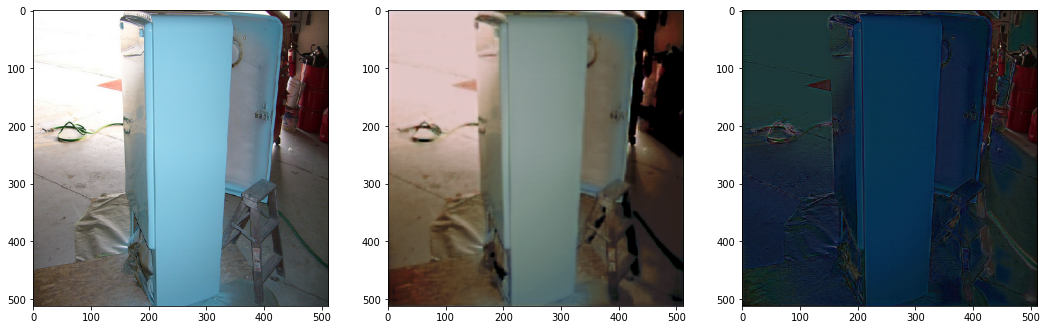

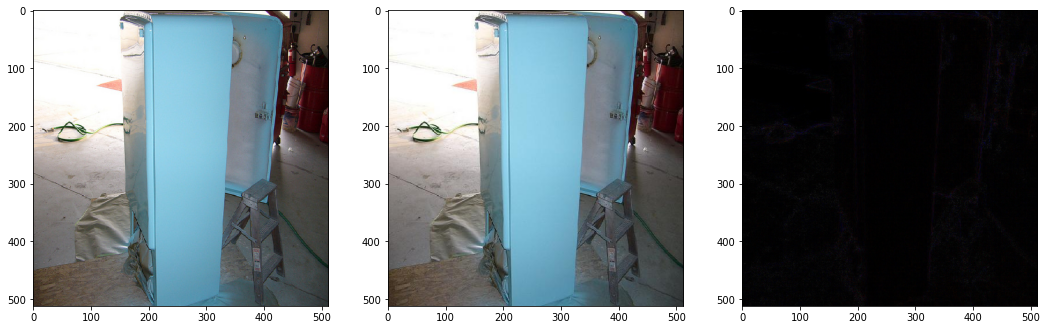

In [28]:
ix = np.random.randint(0, len(ds))

# visualize AutoEncoder compression
fig, ax = plt.subplots(1, 3, figsize=(18, 12))
input_img = denormalize(ds[ix]).int()

ds.plot(input_img, ax[0])
with torch.inference_mode():
    tmp = auto_encoder.forward(ds[ix].unsqueeze(0).to("cuda"))[0].cpu()
    tmp = denormalize(tmp).int()
ds.plot(tmp, ax[1])
ds.plot(torch.abs(tmp - input_img) / 255., ax[2])
plt.show()

# visualize JPEG compression
fig, ax = plt.subplots(1, 3, figsize=(18, 12))
ds.plot(input_img, ax[0])

# JPEG encode and decode
img_bytes =  io.BytesIO()
Image.fromarray(input_img.numpy().transpose([1, 2, 0]).astype(np.uint8)).save(img_bytes, format="JPEG")
jpg_img = Image.open(io.BytesIO(img_bytes.getvalue()))
ax[1].imshow(jpg_img)

jpg_tensor = torch.from_numpy(np.array(jpg_img).transpose(2, 0, 1))
ds.plot(torch.abs(input_img - jpg_tensor) / 255., ax[2])
plt.show()

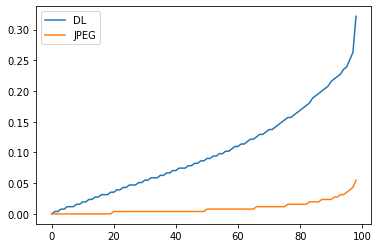

In [24]:
plt.plot(
    np.quantile((torch.abs(tmp - input_img) / 255.).cpu().numpy(), 
    np.arange(0.01, 1, 0.01)),
    label="DL"
)
plt.plot(
    np.quantile((torch.abs(input_img - jpg_tensor) / 255.).cpu().numpy(),
    np.arange(0.01, 1, 0.01)),
    label="JPEG"
)
plt.gca().legend()
plt.show()